In [1]:
import os, json
from PIL import Image, ImageDraw, ImageFont,ImageFilter
import PIL.Image
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import cv2
import scipy.special
import scipy.misc
import math
from utils import *

In [2]:
sentence = ''
pt = 28 # global variable defination
for line in open('./common-standard-chinese-characters-table-master/level-1.txt','r'):
    rs = line.replace('\n','')
    sentence =sentence + rs
for line in open('./common-standard-chinese-characters-table-master/level-2.txt','r'):
    rs = line.replace('\n','')
    sentence =sentence + rs
    
sentence = sentence[20:50]
print('The length of the sentence is {}'.format(len(sentence)))

The length of the sentence is 30


In [5]:
npz_char(sentence, pt = pt, fontname1 = "Songti.ttc", fontname2 = "STHeiti Medium.ttc")

The length of the sentence_train is 30
For Songti.ttc, the offset is -5.683333333333334
For STHeiti Medium.ttc, the offset is -1.2833333333333334
The length of the sentence_valid is 6


In [6]:
data = np.load('/Users/Giatti/Desktop/AI篆刻/ImageMoments/char_moments.npz')

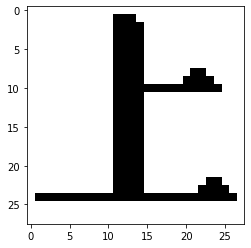

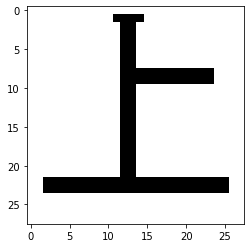

data type: int8


In [7]:
train_A = np.abs(1-data['X_train']).reshape(data['X_train'].shape[0],pt,pt).astype("int8")
train_B = np.abs(1-data['y_train']).reshape(data['y_train'].shape[0],pt,pt).astype("int8")
valid_A = np.abs(1-data['X_valid']).reshape(data['X_valid'].shape[0],pt,pt).astype("int8")
valid_B = np.abs(1-data['y_valid']).reshape(data['y_valid'].shape[0],pt,pt).astype("int8")

valid_A[0] = train_A[15]
valid_B[0] = train_B[15]

plt.imshow(valid_A[0],'gray')
plt.show()
plt.imshow(valid_B[0],'gray')
plt.show()
print("data type:", train_A[0].dtype.name)

## Moments Processing

In [8]:
k = 28 # k = pt
n = 31 #order
sigma = 0.9*n**(-0.52) # select scale parameter sigma
print("order =", n)
print("sigma =",sigma)
M = np.zeros((n+1,n+1), dtype="double")
F = np.zeros((k,k), dtype="double")

# Q is the storage for Guassian_Hermite polynominal, shape = (n+1,k) <-- (p,i).  p [0,n] and i [0,k-1]
Q = discrete_hermite_Q(n,k,sigma)

train_size = train_A.shape[0] ; print("train_size =", train_size)  # 30 
valid_size = valid_A.shape[0] ; print("valid_size =", valid_size)  # 6
train_A_M = np.zeros((train_size,n+1,n+1), dtype='double')
train_B_M = np.zeros((train_size,n+1,n+1), dtype='double')
valid_A_M = np.zeros((valid_size,n+1,n+1), dtype='double')
valid_B_M = np.zeros((valid_size,n+1,n+1), dtype='double')

def char_to_moment(size, char_array, M_array):
        # transfer the char_array to M_array
    # ex. for the training set: [train_size,pt,pt] --> [train_size,order+1,order+1]
    for i in range(size):
        F = char_array[i].T
        M = np.dot(np.dot(Q,F),Q.T)
        M_array[i] = M
    return

char_to_moment(train_size,train_A,train_A_M)
char_to_moment(train_size,train_B,train_B_M)
char_to_moment(valid_size,valid_A,valid_A_M)
char_to_moment(valid_size,valid_B,valid_B_M)

# for i in range(train_size):
#     F = train_A[i].T
#     M = np.dot(np.dot(Q,F),Q.T)
#     train_A_M[i] = M


order = 31
sigma = 0.15091570214573066
train_size = 30
valid_size = 6


### Grouping:M->4m

In [9]:
# bn -- before normalization
m_size = int(((n+1)/2)**2)
train_A_4m_bn = np.zeros((4,train_A_M.shape[0],m_size))
train_B_4m_bn = np.zeros((4,train_B_M.shape[0],m_size))
valid_A_4m_bn = np.zeros((4,valid_A_M.shape[0],m_size))
valid_B_4m_bn = np.zeros((4,valid_B_M.shape[0],m_size))
train_A_4m = np.zeros((4,train_A_M.shape[0],m_size))
train_B_4m = np.zeros((4,train_B_M.shape[0],m_size))
valid_A_4m = np.zeros((4,valid_A_M.shape[0],m_size))
valid_B_4m = np.zeros((4,valid_B_M.shape[0],m_size))
print(train_A_4m_bn.dtype.name)
print(train_A_4m_bn.shape) #((31+1)/2)**2 = 256
# Normalization
train_A_4m_bn[0] = train_A_M[:,::2,::2].reshape((train_A_M.shape[0],-1))
train_B_4m_bn[0] = train_B_M[:,::2,::2].reshape((train_B_M.shape[0],-1))
valid_A_4m_bn[0] = valid_A_M[:,::2,::2].reshape((valid_A_M.shape[0],-1))
valid_B_4m_bn[0] = valid_B_M[:,::2,::2].reshape((valid_B_M.shape[0],-1))

train_A_4m_bn[1] = train_A_M[:,1::2,1::2].reshape((train_A_M.shape[0],-1))
train_B_4m_bn[1] = train_B_M[:,1::2,1::2].reshape((train_B_M.shape[0],-1))
valid_A_4m_bn[1] = valid_A_M[:,1::2,1::2].reshape((valid_A_M.shape[0],-1))
valid_B_4m_bn[1] = valid_B_M[:,1::2,1::2].reshape((valid_B_M.shape[0],-1))

train_A_4m_bn[2] = train_A_M[:,1::2,::2].reshape((train_A_M.shape[0],-1))
train_B_4m_bn[2] = train_B_M[:,1::2,::2].reshape((train_B_M.shape[0],-1))
valid_A_4m_bn[2] = valid_A_M[:,1::2,::2].reshape((valid_A_M.shape[0],-1))
valid_B_4m_bn[2] = valid_B_M[:,1::2,::2].reshape((valid_B_M.shape[0],-1))

train_A_4m_bn[3] = train_A_M[:,::2,1::2].reshape((train_A_M.shape[0],-1))
train_B_4m_bn[3] = train_B_M[:,::2,1::2].reshape((train_B_M.shape[0],-1))
valid_A_4m_bn[3] = valid_A_M[:,::2,1::2].reshape((valid_A_M.shape[0],-1))
valid_B_4m_bn[3] = valid_B_M[:,::2,1::2].reshape((valid_B_M.shape[0],-1))

# [4,30,16*16]

# Normalization
max_4m = []
min_4m = []
for i in range(4):
    local_max = max(max(train_A_4m_bn[i].ravel()), max(train_B_4m_bn[i].ravel()),\
                    max(valid_A_4m_bn[i].ravel()), max(valid_B_4m_bn[i].ravel()))
    local_min = min(min(train_A_4m_bn[i].ravel()), min(train_B_4m_bn[i].ravel()),\
                    min(valid_A_4m_bn[i].ravel()), min(valid_B_4m_bn[i].ravel()))  
    print(local_max,local_min)
    max_4m.append(local_max)
    min_4m.append(local_min)
    
    train_A_4m[i] = (train_A_4m_bn[i]-local_min)/(local_max-local_min)
    train_B_4m[i] = (train_B_4m_bn[i]-local_min)/(local_max-local_min)
    valid_A_4m[i] = (valid_A_4m_bn[i]-local_min)/(local_max-local_min)
    valid_B_4m[i] = (valid_B_4m_bn[i]-local_min)/(local_max-local_min)
    
#     train_A_4m[i] = (train_A_4m_bn[i]-min(train_A_4m_bn[i].ravel()))/(max(train_A_4m_bn[i].ravel())-min(train_A_4m_bn[i].ravel()))
#     train_B_4m[i] = (train_B_4m_bn[i]-min(train_B_4m_bn[i].ravel()))/(max(train_B_4m_bn[i].ravel())-min(train_B_4m_bn[i].ravel()))
#     valid_A_4m[i] = (valid_A_4m_bn[i]-min(valid_A_4m_bn[i].ravel()))/(max(valid_A_4m_bn[i].ravel())-min(valid_A_4m_bn[i].ravel()))
#     valid_B_4m[i] = (valid_B_4m_bn[i]-min(valid_B_4m_bn[i].ravel()))/(max(valid_B_4m_bn[i].ravel())-min(valid_B_4m_bn[i].ravel()))

np.savez('/Users/Giatti/Desktop/AI篆刻/ImageMoments/max_min.npz', max_4m=max_4m, min_4m=min_4m)


float64
(4, 30, 256)
97.31011621722152 -30.268835655858407
35.00401603996602 -29.53651193632801
44.83231781358894 -41.941833267015205
31.23121804102954 -37.993123564333985


# TESTING

In [10]:
# temp_M_AB = np.zeros((n+1,n+1),dtype='float64')
# temp_M_AB[::2,::2] = (valid_A_4m_bn[0][0].reshape((16,16)) + valid_B_4m_bn[0][0].reshape((16,16)))/2
# temp_M_AB[1::2,1::2] = (valid_A_4m_bn[1][0].reshape((16,16)) + valid_B_4m_bn[1][0].reshape((16,16)))/2
# temp_M_AB[1::2,::2] = (valid_A_4m_bn[2][0].reshape((16,16)) + valid_B_4m_bn[2][0].reshape((16,16)))/2
# temp_M_AB[::2,1::2] = (valid_A_4m_bn[3][0].reshape((16,16)) + valid_B_4m_bn[3][0].reshape((16,16)))/2

阈值是: 0.7370737419061874 
order是: 31


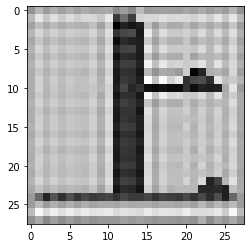

In [11]:
img_rec, img_nor_binary_rec = img_recover(n,Q,valid_A_M[0],valid_A[0])
plt.imshow(img_rec,'gray')
plt.show()

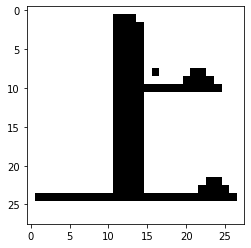

In [12]:
plt.imshow(img_nor_binary_rec,'gray')
plt.show()


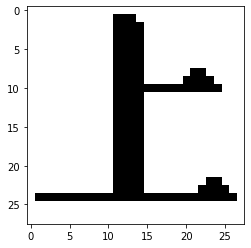

In [13]:
plt.imshow(valid_A[0],'gray')
plt.show()

# TESTING END

### Send to Model

In [14]:
from __future__ import division, print_function
import matplotlib
import matplotlib.pyplot as plt
from IPython.display import Image, display, clear_output
%matplotlib nbagg
%matplotlib inline 
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
import sklearn.datasets
import tensorflow as tf
from tensorflow.python.framework.ops import reset_default_graph
# import tensorflow as tf
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
print(tf.__version__)
from tensorflow.contrib.layers import fully_connected
from tensorflow.python.ops.nn import relu, sigmoid

/anaconda3/envs/AI_char/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/envs/AI_char/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/envs/AI_char/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/envs/AI_char/lib/python3.6/site-packages/tensorflow/python/framework

Instructions for updating:
non-resource variables are not supported in the long term


/anaconda3/envs/AI_char/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/envs/AI_char/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/envs/AI_char/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/envs/AI_char/lib/python3.6/site-packages/tensor

1.14.0


In [15]:
num_features = train_A_4m[0].shape[1]
print("num_features:", num_features)
# reset graph
reset_default_graph()

# define the model
A = tf.placeholder(tf.float32, [None, num_features], 'A')
B = tf.placeholder(tf.float32, [None, num_features], 'B')
enc_1 = fully_connected(inputs=A, num_outputs=128, activation_fn=relu, scope='enc_1')
enc_2 = fully_connected(inputs=enc_1, num_outputs=32, activation_fn=relu, scope='enc_2')
l_z = fully_connected(inputs=enc_2, num_outputs=4, activation_fn=None, scope='l_z') # None indicates a linear output.
dec_2 = fully_connected(inputs=l_z, num_outputs=32, activation_fn=relu, scope='dec_2')
dec_1 = fully_connected(inputs=dec_2, num_outputs=128, activation_fn=relu, scope='dec_1')
A_hat = fully_connected(inputs=dec_1, num_outputs=num_features, activation_fn=sigmoid) # iid pixel intensities between 0 and 1.

# calculate loss
# loss_per_pixel = tf.square(tf.subtract(A_hat, B))
loss_per_pixel = tf.square(tf.subtract(A_hat, B))
loss = tf.reduce_mean(loss_per_pixel, name="mean_square_error")

# define our optimizer
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.25)

# make training op for applying the gradients
train_op = optimizer.minimize(loss)

num_features: 256


#### Clear Arguments in the Model

In [16]:
# test the forward pass
_A_test = np.zeros(shape=(32, num_features))
_B_targets = np.zeros(shape=(32, num_features))
# initialize the Session
sess = tf.Session()
# test the forward pass
sess.run(tf.initialize_all_variables())
feed_dict = {A: _A_test, B: _B_targets}
res_forward_pass = sess.run(fetches=[A_hat, loss], feed_dict=feed_dict)
print("A_hat", res_forward_pass[0].shape)
print(loss)
# in this case, the learned arguments are all zero

Instructions for updating:
Use `tf.global_variables_initializer` instead.
A_hat (32, 256)
Tensor("mean_square_error:0", shape=(), dtype=float32)


In [17]:
def run_model(M_train_A, M_train_B, M_valid_A, M_valid_B, file_index, batch_size=3, num_epochs=150):
    reset_default_graph()
    # define the model
    A = tf.placeholder(tf.float32, [None, num_features], 'A')
    B = tf.placeholder(tf.float32, [None, num_features], 'B')
    enc_1 = fully_connected(inputs=A, num_outputs=128, activation_fn=relu, scope='enc_1')
    enc_2 = fully_connected(inputs=enc_1, num_outputs=32, activation_fn=relu, scope='enc_2')
    l_z = fully_connected(inputs=enc_2, num_outputs=4, activation_fn=None, scope='l_z') # None indicates a linear output.
    dec_2 = fully_connected(inputs=l_z, num_outputs=32, activation_fn=relu, scope='dec_2')
    dec_1 = fully_connected(inputs=dec_2, num_outputs=128, activation_fn=relu, scope='dec_1')
    A_hat = fully_connected(inputs=dec_1, num_outputs=num_features, activation_fn=sigmoid) # iid pixel intensities between 0 and 1.
    # calculate loss
    # loss_per_pixel = tf.square(tf.subtract(A_hat, B))
    loss_per_pixel = tf.square(tf.subtract(A_hat, B))
    loss = tf.reduce_mean(loss_per_pixel, name="mean_square_error")
    # define our optimizer
    optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.25)
    # make training op for applying the gradients
    train_op = optimizer.minimize(loss)
    
    
    # test the forward pass
    _A_test = np.zeros(shape=(32, num_features))
    _B_targets = np.zeros(shape=(32, num_features))
    # initialize the Session
    sess = tf.Session()
    # test the forward pass
    sess.run(tf.initialize_all_variables())
    feed_dict = {A: _A_test, B: _B_targets}
    res_forward_pass = sess.run(fetches=[A_hat, loss], feed_dict=feed_dict)
    #print("A_hat", res_forward_pass[0].shape)     # A_hat (32, 256)
    #print(loss)      # Tensor("mean_square_error:0", shape=(), dtype=float32)
    # in this case, the learned arguments are all zero

    
    num_samples_train = M_train_A.shape[0] # 3500 #30  30*256 
    num_batches_train = num_samples_train // batch_size
    updates = []
    train_loss = []
    valid_loss = []
    cur_loss = 0
    reset_default_graph()
    plt.figure(figsize=(12, 12))
    
    num_char_dim = 1
    display_size = int((n+1)/2) # n = order = 32
    # global variable pt = 256 is defined in Pre-processing[4]
    
    try:
        for epoch in range(num_epochs):
            #Forward->Backprob->Update params
            cur_loss = []
            for i in range(num_batches_train):
                idxs = np.random.choice(range(M_train_A.shape[0]), size=(batch_size), replace=False)    
                x_A_batch = M_train_A[idxs]
                x_B_batch = M_train_B[idxs]
                # setup what to fetch, notice l
                fetches_train = [train_op, loss, A_hat, l_z]
                feed_dict_train = {A: x_A_batch, B: x_B_batch}    # --------------------
                # do the complete backprob pass
                res_train = sess.run(fetches_train, feed_dict_train)
                _, batch_loss, train_out, train_z = tuple(res_train)
                cur_loss += [batch_loss]
            train_loss += [np.mean(cur_loss)]
            updates += [batch_size*num_batches_train*(epoch+1)] # batch_size*num_batches_train =num_samples_train
    
            # Evaluate     # train_op not used for optimizing!!!
            fetches_eval = [loss, A_hat, l_z]
            ##################### select the valid set #####################
            feed_dict_eval = {A: M_valid_A, B: M_valid_B}      # -----------------------
            res_valid = sess.run(fetches_eval, feed_dict_eval)       
            eval_loss, eval_out, eval_z = tuple(res_valid)
            valid_loss += [eval_loss]

            if epoch == 0:
                continue

            # Plotting
            idx = 0
            plt.subplot(2,2,1)
            plt.cla() # clear the plot on the this(current) figure
            plt.title('Error')
            plt.xlabel('Updates'); plt.ylabel('Error')
            plt.plot(updates, train_loss, color="red")
            plt.plot(updates, valid_loss, color="blue")
            plt.legend(['Train Error', 'Valid Error'])
            plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
            plt.grid('on')

            plt.subplot(2,2,2)
            plt.cla()
            plt.title("Target Outputs")
            plt.axis('off')
    #         print(eval_out)
            plt.imshow(eval_out[idx].reshape((display_size, display_size)))
            
            plt.subplot(2,2,3)
            plt.cla()
            plt.title("Source Fonts")
            plt.axis('off')
    #         print(M_valid_A[0])
            plt.imshow(M_valid_A[idx].reshape((display_size, display_size)))
                    
            plt.subplot(2,2,4)
            plt.cla()
            plt.title("Target Fonts")
            plt.axis('off')
#             print(M_valid_B[idx])
            plt.imshow(M_valid_B[idx].reshape((display_size, display_size)))
            
                       
            filename = str(file_index) + "_output_epoch" + str(num_epochs) + "_pt" + str(pt) + ".png"
            plt.savefig(filename)
            display(Image(filename=filename))
            
    #         plt.savefig("output.png")
    #         display(Image(filename="output.png"))
            clear_output(wait=True)
    except KeyboardInterrupt:
        pass 
    sess.close()
    return eval_out

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x111c2d2f0> (for post_execute):


IndexError: list index out of range

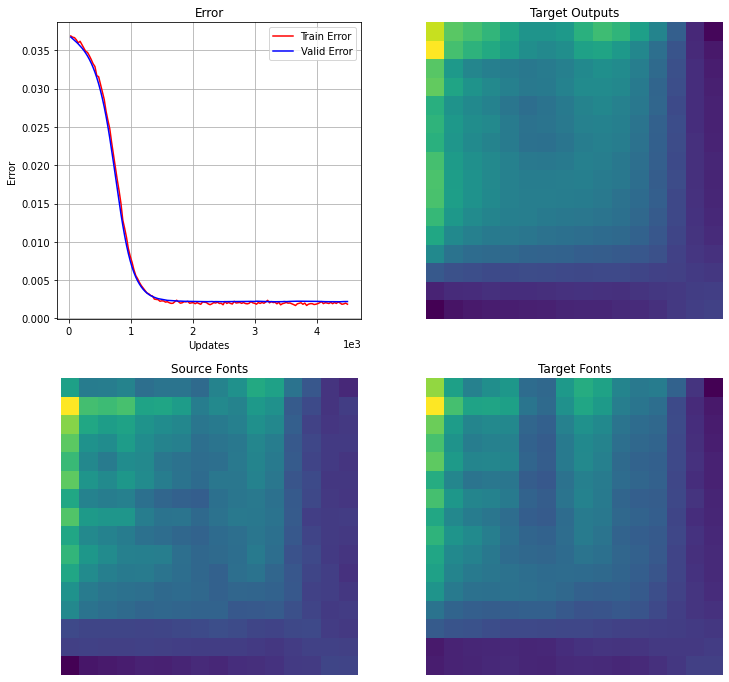

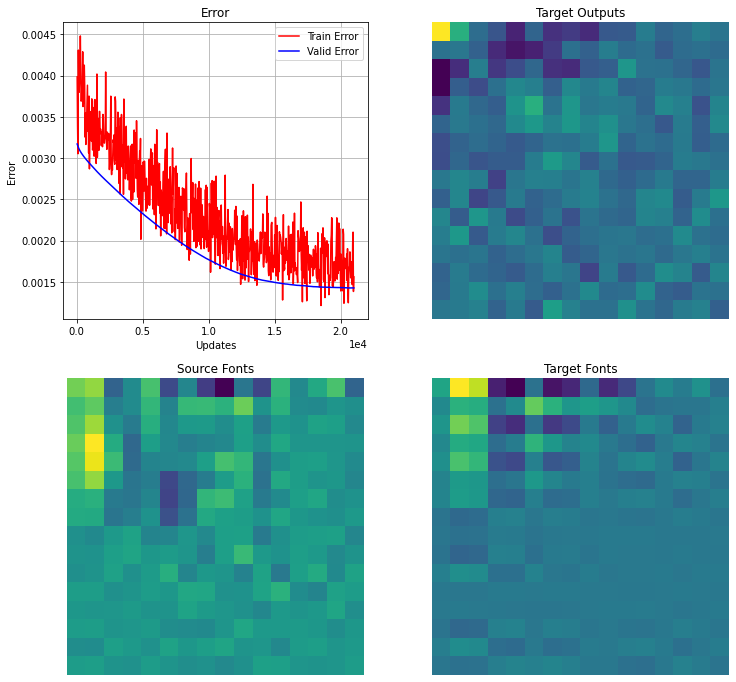

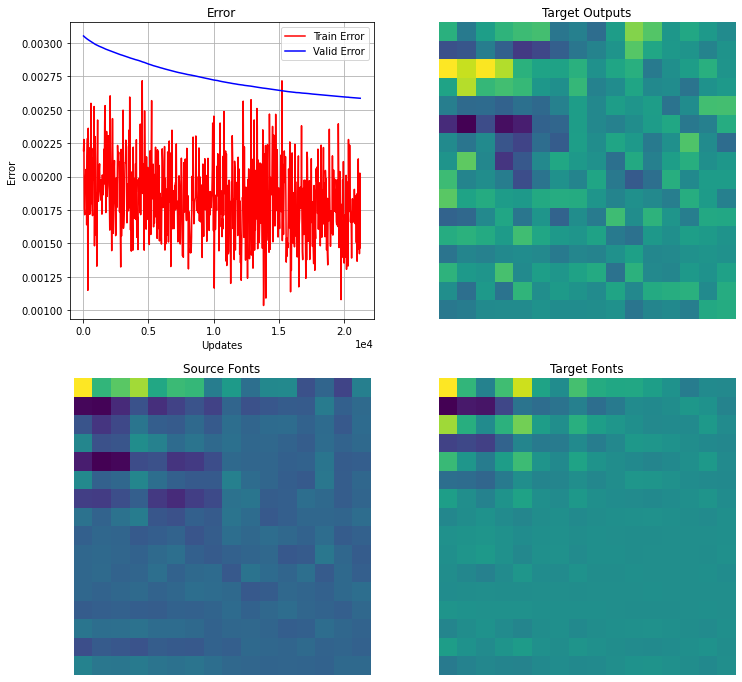

IndexError: list index out of range

<Figure size 864x864 with 4 Axes>

In [18]:
target_m0 = run_model(train_A_4m[0], train_B_4m[0], valid_A_4m[0], valid_B_4m[0],0)
print("target_m0 finished")
target_m1 = run_model(train_A_4m[1], train_B_4m[1], valid_A_4m[1], valid_B_4m[1],1,num_epochs=700)
print("target_m1 finished")
target_m2 = run_model(train_A_4m[2], train_B_4m[2], valid_A_4m[2], valid_B_4m[2],2,num_epochs=800)
print("target_m2 finished")
target_m3 = run_model(train_A_4m[3], train_B_4m[3], valid_A_4m[3], valid_B_4m[3],3,num_epochs=800)
print("target_m3 finished")

In [40]:
np.savez('/Users/Giatti/Desktop/AI篆刻/ImageMoments/data_shang/m4.npz', target_m0 = target_m0, \
         target_m1 = target_m1, target_m2 = target_m2, target_m3 = target_m3)

## Post-processing

In [42]:
data_shang = np.load('/Users/Giatti/Desktop/AI篆刻/ImageMoments/data_shang/m4.npz')

In [43]:
data_shang.files

['target_m0', 'target_m1', 'target_m2', 'target_m3']

### Trial

In [ ]:
F_rec = np.dot(np.dot(Q.T,valid_A_M[0]),Q)
img_rec = F_rec.T
plt.imshow(img_rec,'gray')
plt.show()

In [ ]:
M = train_B_M[0]
M_0 = M[::2,::2] 
M_1 = M[1::2,1::2]
M_2 = M[1::2,::2]
M_3 = M[::2,1::2]
plt.figure(figsize=(15, 15)) 
plt.subplot(151); plt.imshow(M)
plt.subplot(152); plt.imshow(M_0)
plt.subplot(153); plt.imshow(M_1)
plt.subplot(154); plt.imshow(M_2)
plt.subplot(155); plt.imshow(M_3)
plt.show()

In [ ]:
plt.subplot(221)
plt.imshow(train_A_4m_bn[0][0].reshape(16,16))
plt.subplot(222)
plt.imshow(train_B_4m_bn[0][0].reshape(16,16))
plt.subplot(223)
plt.imshow(train_A_4m[0][0].reshape(16,16))
plt.subplot(224)
plt.imshow(train_B_4m[0][0].reshape(16,16))
